# Fine tuning classification example

We will fine-tune an ada classifier to distinguish between the two sports: Baseball and Hockey.

In [1]:
!pip install --quiet openai

     |████████████████████████████████| 44 kB 753 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 146 kB 60.9 MB/s 


In [2]:
!pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import yaml

def read_yaml(path_to_yaml: str) -> dict:
    with open(path_to_yaml) as yaml_file:
        content = yaml.safe_load(yaml_file)
    
    return content


In [6]:
SECRET = read_yaml("/content/api_secret.yaml")
OPENAI_API_SECRET = SECRET['OPENAI_API_SECRET']

In [5]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai

categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

 ## Data exploration
 The newsgroup dataset can be loaded using sklearn. First we will look at the data itself:

In [6]:
print(sports_dataset['data'][0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

In [7]:
sports_dataset['target_names']

['rec.sport.baseball', 'rec.sport.hockey']

In [8]:
sports_dataset.target_names[sports_dataset['target'][0]]


'rec.sport.baseball'

In [9]:
len_all, len_baseball, len_hockey = len(sports_dataset.data), len([e for e in sports_dataset.target if e == 0]), len([e for e in sports_dataset.target if e == 1])
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

Total examples: 1197, Baseball examples: 597, Hockey examples: 600


One sample from the baseball category can be seen above. It is an email to a mailing list. We can observe that we have 1197 examples in total, which are evenly split between the two sports.

## Data Preparation
We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [10]:
import pandas as pd

labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


Both baseball and hockey are single tokens. We save the dataset as a jsonl file.

In [11]:
df.to_json("sport2.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [12]:
!openai tools fine_tunes.prepare_data -f sport2.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases. 

In [19]:
!openai --api-key OPENAI_API_SECRET api fine_tunes.create -t "sport2_prepared_train.jsonl" -v "sport2_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " baseball" -m ada

Upload progress: 100% 1.52M/1.52M [00:00<00:00, 3.68Git/s]
Uploaded file from sport2_prepared_train.jsonl: file-UZDuOYoWwCs7Mkou1N9Kcc5D
Upload progress: 100% 387k/387k [00:00<00:00, 901Mit/s]
Uploaded file from sport2_prepared_valid.jsonl: file-LLaOJvQcNz1BblM8vbzbCWZS
Created fine-tune: ft-gJqa3uh0RYW7x8R0VSMcBitG
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-12-02 06:47:50] Created fine-tune: ft-gJqa3uh0RYW7x8R0VSMcBitG
[2022-12-02 06:48:11] Fine-tune costs $0.78
[2022-12-02 06:48:12] Fine-tune enqueued. Queue number: 0
[2022-12-02 06:48:13] Fine-tune started
[2022-12-02 06:50:48] Completed epoch 1/4
[2022-12-02 06:53:19] Completed epoch 2/4
[2022-12-02 06:55:49] Completed epoch 3/4
[2022-12-02 06:58:18] Completed epoch 4/4
[2022-12-02 06:58:49] Uploaded model: ada:ft-personal-2022-12-02-06-58-49
[2022-12-02 06:58:50] Uploaded result file: file-xzINAgAQi67R50k6lXOsUsuj
[2022-12-02 06:58:50] Fine-tune succeed

The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [21]:
!openai --api-key OPENAI_API_SECRET api fine_tunes.results -i ft-2zaA7qi0rxJduWQpdvOvmGn3 > result.csv

[organization=user-zcbbgciownltezxvlu9n684t] Error: No fine-tune job: ft-2zaA7qi0rxJduWQpdvOvmGn3 (HTTP status code: 404)


In [22]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

EmptyDataError: ignored

The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run. 

<AxesSubplot:>

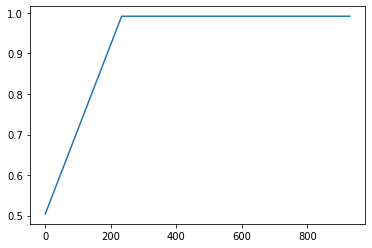

In [ ]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

In [ ]:
test = pd.read_json('sport2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball


We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [ ]:
ft_model = 'ada:ft-openai-2021-07-30-12-26-20'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']


' hockey'

To get the log probabilities, we can specify logprobs parameter on the completion request

In [ ]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7fe114e435c8> JSON: {
  " baseball": -7.6311407,
  " hockey": -0.0006307676
}

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.

### Generalization
Interestingly, our fine-tuned classifier is quite versatile. Despite being trained on emails to different mailing lists, it also successfully predicts tweets.

In [ ]:
sample_hockey_tweet = """Thank you to the 
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the 
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [ ]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'